In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

NN은 데이터와 레이블을 기반으로 규칙을 추측하는 함수 예. $ f(data,label) = rules$
- sequence 를 무시함 예. 재귀 예시 :피보나치 수열 $n_x =n_{x-1} +x_{n-2}$
재귀와 순환 신경은 다른 의미

## RNN(Recurrent Neural Network) 
- 순환신경망: 이전 함수의 출력값(y0)을 다음 함수의 입력값(x1)의 한 부분으로 받음
- 이러한 chain처럼 연결된 RNN은  sequence나 list와 같은 데이터에서 과거 정보를 학습 가능

- **cell**:RNN에서 은닉층에서 활성화 함수를 통해 결과를 내보내는 역할을 하는 노드이며 이전의 값을 기억하려고 하는 일종의 메모리 역할을 수행

- 현재 시점 t에서의 메모리 셀이 갖고있는 값은 과거의 메모리 셀들의 값에 영향을 받음

- hidden state: 메모리 셀이 출력층 방향으로 또는 다음 시점 t+1에 보내는 값


### 문제점
-  짧은 sequence에 대해서만 결과가 좋아 시점이 멀어질 수록 이전의 정보가 손실되어 나중에 충분히 전달되지 못하는 현상이 발생(gradient vanishing problem!!)
- 예. the clouds are in the *sky*과 같이 짧은 문장에서는 근처의 몇개만 보고도 유추가 가능 
- 예2.I grew up in France… I speak fluent *French*. 두 문장을 보고 유추해야 하는데 못 하게됨



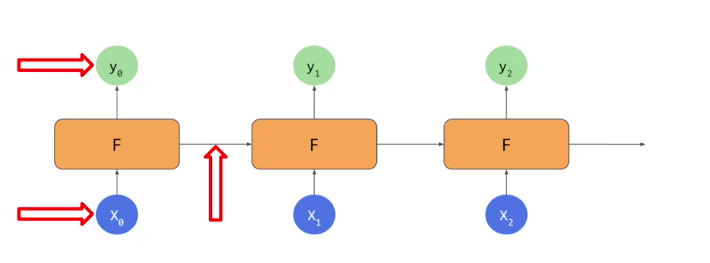


- [Deep RNNs](https://www.coursera.org/lecture/nlp-sequence-models/deep-rnns-ehs0S)

## Long Short-Term Memory, LSTM
- 장단기 메모리: RNN의 장기 의존성 문제(the problem of Long-Term Dependencies) 피하기 위해 설계됨 
- vanila RNN에는 tanh 활성함수로 간단하게 되어있지만 cell state에서 정보를 추가할지 없앨지 정하는 gate가 존재
  -  input gate, forget gate 통해서 사람의 뇌와 같이 과거의 불필요한 정보를 지우고, 현재 정보의 기억해야할 것들을 정함
- bidirectional LSTM 도 있음

- [LSTM ](https://www.coursera.org/lecture/nlp-sequence-models/long-short-term-memory-lstm-KXoay)
- 참고 : http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow_datasets as tfds
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
# Get the data ; 8000개  subwords 학습에 사용-> OOV많을 것
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteP0HT09/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteP0HT09/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteP0HT09/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [4]:
tokenizer = info.features['text'].encoder

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)
test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


In [6]:
import matplotlib.pyplot as plt
#smoother training curve

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Single Layer LSTM

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NUM_EPOCHS = 50
history1 = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 60s 153ms/step - loss: 0.5108 - accuracy: 0.7460 - val_loss: 0.4749 - val_accuracy: 0.8020
Epoch 2/50
391/391 [==============================] - 59s 152ms/step - loss: 0.3524 - accuracy: 0.8582 

# Multiple Layer LSTM

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    #Stacking LSTM: return_sequences=True하고 LSTM 결과를 다음의 LSTM input 맞춤 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NUM_EPOCHS = 50
history2 = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 104s 265ms/step - loss: 0.5774 - accuracy: 0.6875 - val_loss

## Compare Acuuracy and loss of single & multiple layer LSTM
- more layers, smoother

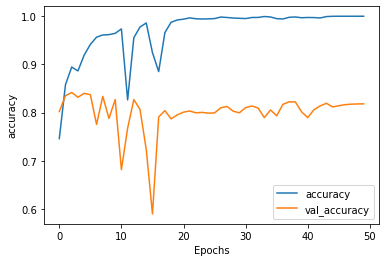

In [9]:
plot_graphs(history1, 'accuracy') #심하게 출렁거림

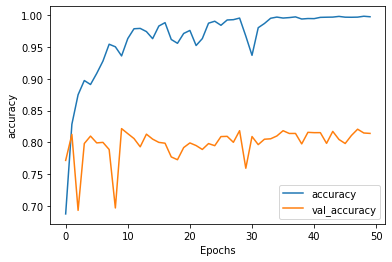

In [10]:
plot_graphs(history2, 'accuracy') 

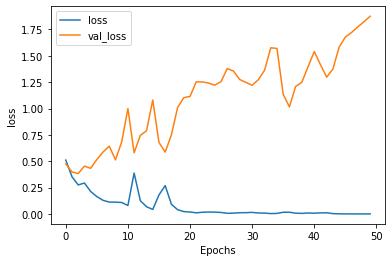

In [11]:
plot_graphs(history1, 'loss') #overfitting 정도가 더 심함

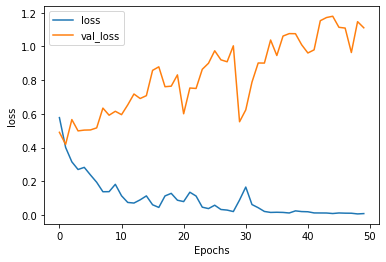

In [12]:
plot_graphs(history2, 'loss')

In [16]:
model = tf.keras.Sequential([
                             
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Conv1D(128, 5, activation='relu'), #( maxlength-5+1, 128)
    tf.keras.layers.GlobalAveragePooling1D(),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NUM_EPOCHS = 10
history3 = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         41088     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 573,249
Trainable params: 573,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
391/391 [==============================] - 25s 65ms/step - loss: 0.4537 - accuracy: 0.7734 - val_loss: 

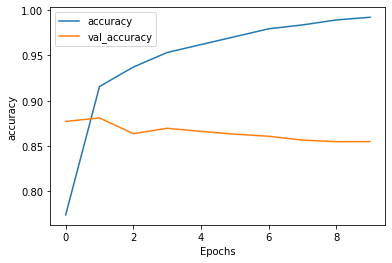

In [17]:
plot_graphs(history3, 'accuracy')  

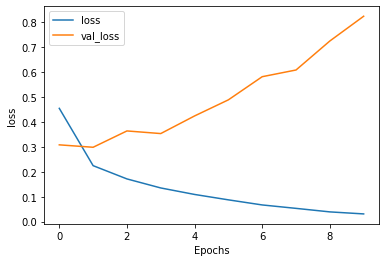

In [18]:
plot_graphs(history3, 'loss')

- /wo LSTM low acc
- /w LSTM good val acc -> overfitting


**Why does sequence make a large difference when determining semantics of language?**

Because the order in which words appear dictate their impact on the meaning of the sentence
**How do Recurrent Neural Networks help you understand the impact of sequence on meaning?**

They carry meaning from one cell to the next
**How does an LSTM help understand meaning when words that qualify each other aren’t necessarily beside each other in a sentence?**

Values from eariler words can be carried to later ones via a cell state
**What keras layer type allows LSTMs to look forward and backward in a sentence?**

Bidirectional
**What’s the output shape of a bidirectional LSTM layer with 64 units?**

(None, 128)
**When stacking LSTMs, how do you instruct an LSTM to feed the next one in the sequence?**

Ensure the return_sequences is set to True only on units that feed to another LSTM

**If a sentence has 120 tokens in it, and a Conv1D with 128 filters with a Kernal size of 5 is passed over it, what’s the output shape?**
(None,116,128)

**What’s the best way to avoid overfitting in NLP datasets?**
- None of the above(LSTMS,GRUs, Conv1D)